# Bayesian Multilevel Modelling using PyStan

This is a tutorial, following through Chris Fonnesbeck's [primer on using PyStan with Bayesian Multilevel Modelling](http://mc-stan.org/documentation/case-studies/radon.html).

# 13. Prediction

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pystan
import seaborn as sns

import clean_data

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Teaching/Teaching-Stan-Hierarchical-Modelling/venv-Teaching-Stan-Hierarchical/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Prediction from a `Stan` model

We're going to make predictions using the contextual effects model developed in notebook `12-contextual_effects.ipynb`. There are two types of prediction that we can make, using a multilevel model:

* predict the outcome for a new individual within an existing group
* predict the outcome for a new individual within a new group

To do this, we sample from the model, choosing values for variable that specify the properties of the individual for which we want to make the prediction.

For instance, if we wanted to make a prediction for a new house, having no basement, in St Louis county, we would sample from the model as:

$$\tilde{y}_{St Louis} \sim N(\alpha_{St Louis} + \beta(x_i = 1), \sigma_y^2)$$

## Specifying the model prediction

To make a prediction from a model, we do the following:

* specify a transformed parameter `stl_mu` ($\mu_{St Louis}$, `real`) to reflect

$$\mu_{St Louis} = \alpha_{St Louis} + \beta_1 u_{St Louis} + \beta_2 + \beta_3 \bar{x}_{St Louis}$$

* add a single additional block in the `Stan` specification: `generated quantities`. In this we define the reported value `y_stl` ($\tilde{y}_{St Louis}$, the predicted value for a new house with no basement in St Louis):

$$\tilde{y}_{St Louis} \sim N(\mu_{St Louis}, \sigma_y^2)$$

This requires that we also detail new data:

* `stl`: $j[i]$, `int` - the index for household $i$ corresponding to St Louis.
* `u_stl`: $u_{St Louis}$, a `real` representing the measured uranium level in St Louis
* `xbar_stl`: $\bar{x}_{St Louis}$, `real`, representing the mean floor measurement in St Louis
* `y_stl`: `real` to hold the predicted value for $\tilde{y}_{St Louis}$

We also introduce `normal_rng()` for the first time - a `Stan` function to produce a realisation from a Normal variate.

Otherwise the model is identical to that in the notebook `12-contextual_effects.ipynb`.

In [2]:
contextual_prediction = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> county[N];
  vector[N] u;
  vector[N] x;
  vector[N] x_mean;
  vector[N] y;
  
  int<lower=0,upper=J> stl;
  real u_stl;
  real xbar_stl;
} 
parameters {
  vector[J] a;
  vector[3] b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  real stl_mu;

  for (i in 1:N)
    y_hat[i] <- a[county[i]] + u[i] * b[1] + x[i] * b[2] + x_mean[i] * b[3];
    
  stl_mu <- a[stl+1] + u_stl * b[1] + b[2] + xbar_stl * b[3];
}
model {
  mu_a ~ normal(0, 1);
  a ~ normal(mu_a, sigma_a);
  b ~ normal(0, 1);
  y ~ normal(y_hat, sigma_y);
}
generated quantities {
  real y_stl;
  
  y_stl <- normal_rng(stl_mu, sigma_y);
}
"""

### Making the prediction

We map Python variables to those in the model, and run the model ust as if we were obtaining a fitted model:

In [3]:
# number of samples from each county
n_county = clean_data.srrs_mn.groupby('county')['idnum'].count()  

# index value for St Louis
idx = clean_data.county_lookup['ST LOUIS']

# Create new variable for mean of floor across counties
xbar = clean_data.srrs_mn.groupby('county')['floor'].mean().rename(clean_data.county_lookup).values
x_mean = xbar[clean_data.county]  # by household

contextual_prediction_data = {'N': len(clean_data.log_radon),
                              'J': len(n_county),
                              'county': clean_data.county+1, # Stan counts starting at 1
                              'u': clean_data.u,
                              'x_mean': x_mean,
                              'x': clean_data.floor_measure,
                              'y': clean_data.log_radon,
                              'stl': idx,
                              'u_stl': np.log(clean_data.cty_mn[clean_data.cty_mn.cty=='STLOUIS'].Uppm.values)[0],
                              'xbar_stl': xbar[idx]}

contextual_prediction_fit = pystan.stan(model_code=contextual_prediction,
                                        data=contextual_prediction_data, 
                                        iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e30261f15e6aa0d3cd7c969dec96741a NOW.


## Inspecting the prediction

We're interested here in the value of `y_stl` ($\tilde{y}_{St Louis}$), which can be drawn from the model fit sample just as if it were any other parameter.

We can plot the distribution of this simulated value:

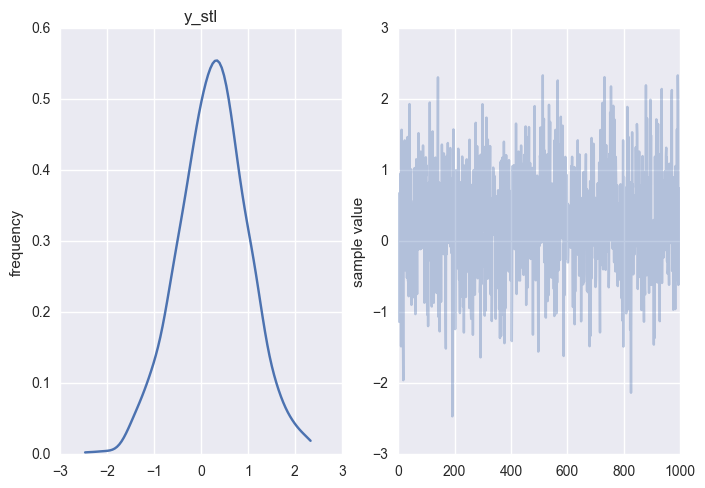

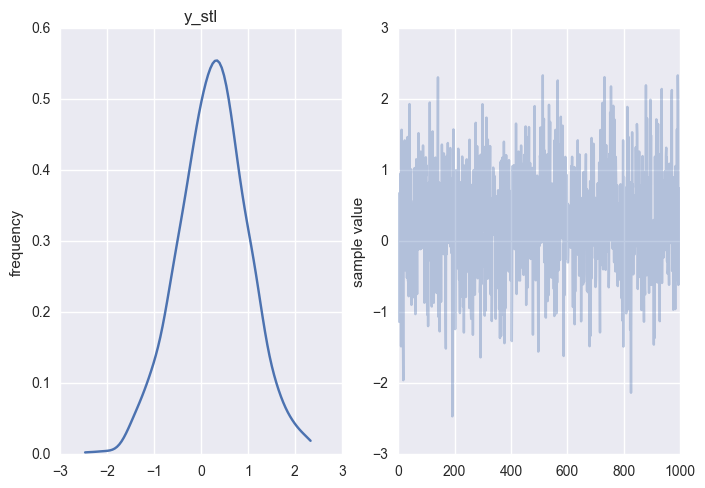

In [4]:
y_stl_mean = contextual_prediction_fit['y_stl'].mean()
contextual_prediction_fit.plot(pars=['y_stl',])

The mean value sampled from this fit is ≈0.3, so we should expect the measured radon level in a new house with no basement in St Louis to be ≈`exp(0.3)` ≈ 1.35, though we can see that the range of predicted values is rather wide.